# Regularization with LASSO
**Computational Packages and Some Practical Issues**

## 0. Overview for the week

### Post-Inference Problem

In previous weeks, you've learned:

- how to make inference (e.g, calculate confidence interval and hypotheses tests) for a fixed model

- how to select a model using stepwise algorithms

However, when we apply a model selection algorithm, we are searching for the combination of variables that will give us the best model (according to a given metric). So the variables in our final models are not fixed; instead, they are selected adaptively based on **the data at hand**. A natural question arises: 

<font color="blue">**Do these model selection algorithms affect the inference about the parameters of the model?**</font> 

> Today, you will investigate this question using a simulation study when a model is selected using a forward selection algorithm.

### Regularized models for variable selection

In previous weeks, you've learned 

- how to select a model using *stepwise* algorithms

    - these are *greedy* algorithms 

    - results depend on the order in which variables are selected 

    - variables are either *in* (i.e., estimated coefficient different from zero) or *out* (i.e., estimated coefficient equal to zero)

A natural question arises: 

<font color="blue">**Can we *smoothly* transition from a $0$ estimated coefficient to an estimated coefficient with a value different from $0$?**</font> 

> Next class, we will learn how to use regularized models to select variables.

## 1. Quick Review of Linear Regression

### 1.1 Linear Regression

The linear regression equation is given by:

$$
Y_i = \beta_0 + \beta_1X_{1i} + \beta_2X_{2i} + \ldots + \beta_pX_{pi} + \varepsilon_i,\quad i=1,\ldots,n
$$ where $\varepsilon$ is a random error.

<br>

### 1.2 Fitting Linear Regression model

Minimize the *residual sum of squares* (RSS):

$$
    RSS(\beta_0, ..., \beta_p) = \sum_{i=1}^n \left(y_i - \beta_0 - \beta_1X_{i1} - \ldots - \beta_p X_{ip}\right)^2
$$




## 2. Application


### 2.1 Loading some packages

Let's start by loading some packages we will need.

In [1]:
# Loading some libraries
library(tidyverse) 
library(tidymodels)
library(knitr)
library(broom)
library(leaps)
library(glmnet)
library(gridExtra)

install.packages('Brq')
library(Brq) # This package contains the data we will use

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ────

### 2.2 Prostate Cancer data

Data on 97 prostate cancer patients.

-   **lcavol**: log(cancer volume)
-   **lweight**: log(prostate weight)
-   **age**: age of the patient
-   **lbph**: log(amount of benign prostatic hyperplasia)
-   **svi**: Seminal vesicle invasion. (True or False)
-   **lcp**: log(capsular penetration)
-   **gleason**: Gleason score. The Gleason score measures how abnormal the tissue looks. The lower the score is, the more the cells look like regular prostate tissue. You can learn more about the [Gleason Score here](https://www.pcf.org/about-prostate-cancer/diagnosis-staging-prostate-cancer/gleason-score-isup-grade/)
-   **pgg45**: Percentage Gleason scores 4 or 5. Scores 4 and 5 are considered very high; the cells barely look like normal prostate tissue.
-   **lpsa**: log(prostate-specific antigen)

We want to model `lpsa`, using the remaining variables as explanatory variables. Let's take a look at our data.

In [2]:
# Loading the data
data("Prostate")
cancer_prostate <- tibble(Prostate)

In [3]:
# Printing the data
cancer_prostate %>% head()

lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.5798185,2.769459,50,-1.386294,0,-1.386294,6,0,-0.4307829
-0.9942523,3.319626,58,-1.386294,0,-1.386294,6,0,-0.1625189
-0.5108256,2.691243,74,-1.386294,0,-1.386294,7,20,-0.1625189
-1.2039728,3.282789,58,-1.386294,0,-1.386294,6,0,-0.1625189
0.7514161,3.432373,62,-1.386294,0,-1.386294,6,0,0.3715636
-1.0498221,3.228826,50,-1.386294,0,-1.386294,6,0,0.7654678


### 2.3 Data splitting

The first thing we need to do is to split the data into a training and a test set.

In [4]:
set.seed(1) # Let's set the seed for reproducibility

cancer_split <- initial_split(cancer_prostate, prop = 0.7)
cancer_train <- training(cancer_split)
cancer_test <- testing(cancer_split)

### 2.4 Data Summary

-   Let's look at some summary statistics from our training set.

In [5]:
summary(cancer_train |> select(-svi))

     lcavol           lweight           age             lbph        
 Min.   :-1.0498   Min.   :2.375   Min.   :44.00   Min.   :-1.3863  
 1st Qu.: 0.6597   1st Qu.:3.395   1st Qu.:60.00   1st Qu.:-1.3863  
 Median : 1.4586   Median :3.683   Median :64.00   Median : 0.4383  
 Mean   : 1.3839   Mean   :3.684   Mean   :63.88   Mean   : 0.1861  
 3rd Qu.: 2.0417   3rd Qu.:3.893   3rd Qu.:68.00   3rd Qu.: 1.6292  
 Max.   : 3.8210   Max.   :6.108   Max.   :77.00   Max.   : 2.3263  
      lcp             gleason          pgg45            lpsa        
 Min.   :-1.3863   Min.   :6.000   Min.   : 0.00   Min.   :-0.4308  
 1st Qu.:-1.3863   1st Qu.:6.000   1st Qu.: 0.00   1st Qu.: 1.9283  
 Median :-0.5978   Median :7.000   Median :15.00   Median : 2.6776  
 Mean   :-0.1920   Mean   :6.731   Mean   :22.99   Mean   : 2.5994  
 3rd Qu.: 0.8109   3rd Qu.:7.000   3rd Qu.:40.00   3rd Qu.: 3.0469  
 Max.   : 2.9042   Max.   :9.000   Max.   :90.00   Max.   : 5.5829  

- Note the difference in units! This will be important.

In [6]:
# The proportion of true for `svi`
round(mean(cancer_train$svi), 3)

[1] 0.209

### 2.5 Fitting Linear Regression in R

In [7]:
# Fitting the linear regression model
cancer_lm <- lm(lpsa ~ ., data = cancer_train)

# Printing the coefficients' information
tidy(cancer_lm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.445164141,1.756911004,0.2533789,8.008714e-01
lcavol,0.565747413,0.110406555,5.1242194,3.576901e-06
lweight,0.399632024,0.204722013,1.9520716,5.576296e-02
age,-0.010531262,0.014990277,-0.7025395,4.851529e-01
lbph,0.064162435,0.074144784,0.8653668,3.904029e-01
svi,0.931233568,0.309218287,3.0115734,3.845797e-03
lcp,-0.067792297,0.116703587,-0.5808930,5.635631e-01
gleason,0.042666597,0.218193059,0.1955452,8.456496e-01
pgg45,0.002836582,0.005302523,0.5349495,5.947299e-01


## 3. Improving OLS


### 3.1 Goals of linear regression

There are mainly two reasons to fit a linear regression model:

-   **Prediction**: We want to predict the response based on the values of the predictors the best we can. So, we want our model to generalize well to unseen data.

-   **Inference**: We are interested in interpreting the association between our response and the predictors and checking their significance.

### 3.2 Variable selection

-   Inference: use the simplest model possible (fewest predictors).
    -   easier to interpret
    -   the principle of parsimony (Occam's razor).

<br> 

-   Variable selection: select a subset of the most important predictors

-   Relevant to inference and prediction

### 3.3 Regularization

-   Helps with the overfitting problem.

-   Overfitting: your model does very well in the training data but poorly in unseen data.

-   Regularization: restrict (or penalize) our optimization.

### 3.3.1 Lasso


#### **Example**

-   To be able to visualize what the LASSO method is doing, let's restrict our attention to a small case of two covariates.

-   Let us consider only two covariates of the Prostate Cancer dataset: `lcavol` and `lweight`.

-   We will consider all the covariates later.

**Step 1: Standardize the covariates**

- Remember, in LASSO, we are penalyzing large $\beta$s. 
    - Units matter!! 

<br> 

- To use LASSO, we **must** standardize the covariates.

- In this case, we will also center the response (this is not required in general).

In [8]:
# Standardizing the predictors and centring the response
cancer_train_std <- 
    cancer_train |>
    select(lcavol, lweight, lpsa) |>
    mutate(lcavol = (lcavol - mean(lcavol)) / sd(lcavol),
           lweight = (lweight - mean(lweight)) / sd(lweight),
           lpsa = (lpsa - mean(lpsa)))

In [9]:
# Let's double-check that everything is in order (for our mental sanity).
cancer_train_std |>
    summarise(across(everything(), list(mean = mean, sd = sd))) |>
    pivot_longer(cols = everything(), names_to = c("variable", '.value'), names_sep = "_")

variable,mean,sd
<chr>,<dbl>,<dbl>
lcavol,-3.388820e-17,1.000000
lweight,-8.566815e-17,1.000000
lpsa,1.657332e-16,1.129692


-   Ok, everything looks good. All variables are centred (i.e., have 0 mean), and only the predictors are scaled (i.e., have std. deviation of 1).

**The model**

Our regression model is:

$$
lpsa_i = \beta_1\times lcavol_i + \beta_2\times lweight_i + \varepsilon_i
$$ 

Note that there's no intercept (we already removed it by centring all the variables).

**OLS**

To fit our regression model using the least square, we need to minimize our RSS:

$$
    RSS(\beta_1, \beta_2) = \sum_{i=1}^n \left(lpsa_i - \beta_1\times lcavol_{i} - \beta_2 \times lweight_{i}\right)^2
$$

In [10]:
# Fit the model using OLS

ols_lm <- lm(lpsa ~ 0 + lcavol + lweight, data = cancer_train_std)

coef_ols_two_vars <- 
    ols_lm  |>
    coef() |>
    as.numeric()

tidy(ols_lm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
lcavol,0.7846688,0.09487858,8.270242,9.668369e-12
lweight,0.2045937,0.09487858,2.156374,3.475968e-02


In [11]:
# The RSS is: 
rss_two_vars <- sum(ols_lm$residuals**2)
rss_two_vars

[1] 37.85916

#### Question

Do you think LASSO will be able to beat OLS and get a smaller RSS? Why or why not?

**LASSO**

-   Now let's apply LASSO.

-   We need to define the constraint. Let's use $\left|\beta_1\right| + \left|\beta_2\right| \leq 0.5$
    -   this is equivalent to using $\lambda = 0.311$;

<br> 

-   the OLS solution would not be a valid solution because $0.7847+ 0.2046 = 0.9893 \geq 0.5$.

-   The only solutions that would be acceptable would be the ones that lie within the square shown in the figure below.

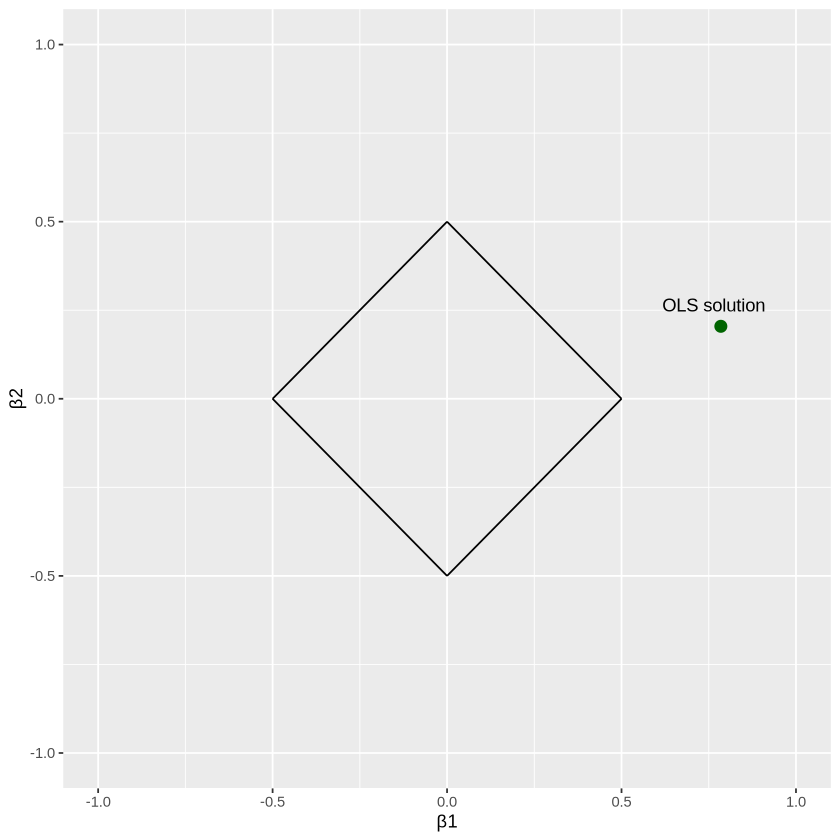

In [12]:
# Plot the feasible region of Beta1 and Beta2 
ggplot(tibble(x1 = -0.5,  x2 = 0, x3 = 0.5, x4 = 0,
              y1 = 0, y2 = 0.5, y3 = 0, y4 = -0.5)) + 
  geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2)) +
  geom_segment(aes(x = x2, y = y2, xend = x3, yend = y3)) +
  geom_segment(aes(x = x3, y = y3, xend = x4, yend = y4)) +
  geom_segment(aes(x = x1, y = y1, xend = x4, yend = y4)) +
  labs(x = 'β1', y = 'β2') +
  xlim(-1, 1) +
  ylim(-1, 1) +
  geom_point(aes(x,y), color = "darkgreen", size = 3, data = tibble(x = coef_ols_two_vars[1], y = coef_ols_two_vars[2])) + 
  annotate("text", x = coef_ols_two_vars[1]-0.02, y = coef_ols_two_vars[2] + 0.06, label = "OLS solution")

- The LASSO method then needs to **shrink** the coefficients until they are in the square.
    - The LASSO solution is the best solution in the feasible region (the square).

In [13]:
fit <- glmnet(cancer_train_std |> select(lcavol, lweight), cancer_train_std$lpsa, lambda = 0.311)
coef(fit)

3 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) 1.938557e-16
lcavol      5.000075e-01
lweight     .           

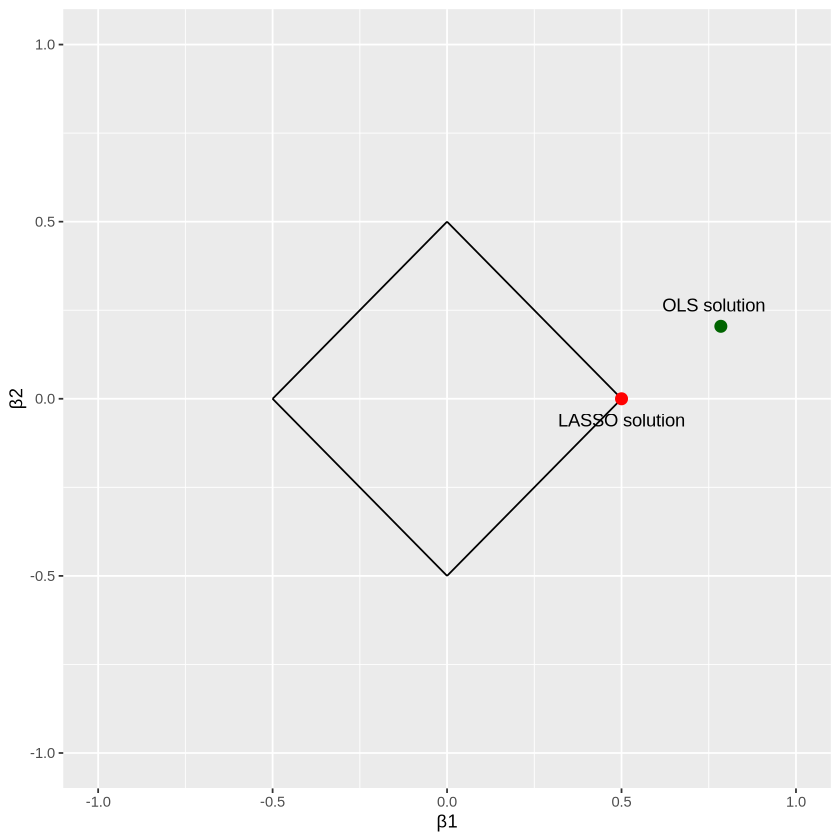

In [14]:
lasso_coef = coef(fit, s=0.311, exact = TRUE)
ggplot(tibble(x1 = -0.5,  x2 = 0, x3 = 0.5, x4 = 0,
              y1 = 0, y2 = 0.5, y3 = 0, y4 = -0.5)) + 
  geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2)) +
  geom_segment(aes(x = x2, y = y2, xend = x3, yend = y3)) +
  geom_segment(aes(x = x3, y = y3, xend = x4, yend = y4)) +
  geom_segment(aes(x = x1, y = y1, xend = x4, yend = y4)) +
  labs(x = 'β1', y = 'β2') +
  xlim(-1, 1) +
  ylim(-1, 1) +
  geom_point(aes(x,y), color = "darkgreen", size = 3, data = tibble(x = coef_ols_two_vars[1], y = coef_ols_two_vars[2])) + 
  annotate("text", x = coef_ols_two_vars[1]-0.02, y = coef_ols_two_vars[2] + 0.06, label = "OLS solution") + 
  geom_point(aes(x,y), color = "red", size = 3, data = tibble(x=lasso_coef[2], y=lasso_coef[3])) + 
  annotate("text", x = lasso_coef[2], y = lasso_coef[3] - 0.06, label = "LASSO solution")

-   The LASSO solution is in a vertice of the square, where one of the coefficients is zero.

-   This is not unusual. The LASSO solution will generally be in a vertice, where one or more of the coefficients are zero.

-   LASSO is also considered a variable selection method. The LASSO coefficients, in this case, were $\beta_1 = 0.5$ and $\beta_2=0$.

# Part 2: Your Turn

## 2.1 Review Questions

**True or False:**

We must standardize the predictors before applying LASSO. 

Why? 

**True or False:**

The penalty term compromises LASSO's ability to fit the intercept term properly. For this reason, we should always center the response.

**True or False:**

When we increase the $\lambda$ value of the penalty term, the absolute value of each coefficient will be reduced by LASSO. 

- Imagine you have a restriction that $|\beta_1|$ and $|\beta_2|$ must be less than 1. 
  - You could have $|\beta_1| = 0.6$ and $|\beta_2| = 0.4$.
  
  <br> 
  
- Now, if we reduce our budget to 0.7. Possible results are:
   - $|\beta_1| = 0.7$ and $|\beta_2| = 0$.
   - $|\beta_1| = 0$ and $|\beta_2| = 0.7$.

- The main idea is that the set of variables selected in a model with 4 variables might have different variables than in a model with 3 variables, or with 2 variables, and so on. 

**True or False:**

When we increase the $\lambda$ value of the penalty term, the sum of the absolute values of the coefficients will be reduced by LASSO. 

**True or False:**

LASSO's solution improves the Residual Sum of Squares in comparison to OLS, which is one of the reasons LASSO is superior to OLS. 

## 2.2 Review the LASSO method

In LASSO, change the OLS objective function by adding a penalty term to it:

$$
LASSO(\beta) = \sum_{i=1}^n \left(y_i - \beta_0 - \beta_1X_{i1} - \ldots - \beta_p X_{ip}\right)^2 + {\color{red}{\lambda\sum_{i=1}^p \left|\beta_i\right|}}
$$

- LASSO regularizes **and** selects features simultaneously;

- The penalty term keeps the coefficients in check;
    1. Large values of $\lambda$ will...?
    2. Small values of $\lambda$ will...?




- LASSO has no closed-form solution. We need to use algorithms; 

In [15]:
options(repr.plot.width = 20, repr.plot.height = 10)


lasso_large_lambda <- ggplot(tibble(x1 = -0.5,  x2 = 0, x3 = 0.5, x4 = 0,
              y1 = 0, y2 = 0.5, y3 = 0, y4 = -0.5)) + 
  geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2)) +
  geom_segment(aes(x = x2, y = y2, xend = x3, yend = y3)) +
  geom_segment(aes(x = x3, y = y3, xend = x4, yend = y4)) +
  geom_segment(aes(x = x1, y = y1, xend = x4, yend = y4)) +
  labs(x = 'β1', y = 'β2', title = 'Large Lambda') +
  xlim(-1, 1) +
  ylim(-1, 1) +
  geom_point(aes(x,y), color = "darkgreen", data = tibble(x=c(0.78), y=c(0.25)), size = 5) + 
  annotate("text", x = 0.78-0.025, y = 0.18, label = "OLS solution", size = 8) + 
  theme(text = element_text(size = 30))


lasso_small_lambda <- ggplot(tibble(x1 = -2,  x2 = 0, x3 = 2, x4 = 0,
              y1 = 0, y2 = 2, y3 = 0, y4 = -2)) + 
  geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2)) +
  geom_segment(aes(x = x2, y = y2, xend = x3, yend = y3)) +
  geom_segment(aes(x = x3, y = y3, xend = x4, yend = y4)) +
  geom_segment(aes(x = x1, y = y1, xend = x4, yend = y4)) +
  labs(x = 'β1', y = 'β2', title = 'Small Lambda') +
  xlim(-3, 3) +
  ylim(-3, 3) +
  geom_point(aes(x,y), color = "darkgreen", data = tibble(x=c(0.78), y=c(0.25)), size = 5) + 
  annotate("text", x = 0.78-0.02, y = 0.025 + 0.06, label = "OLS solution", size = 8) + 
  theme(text = element_text(size = 30))

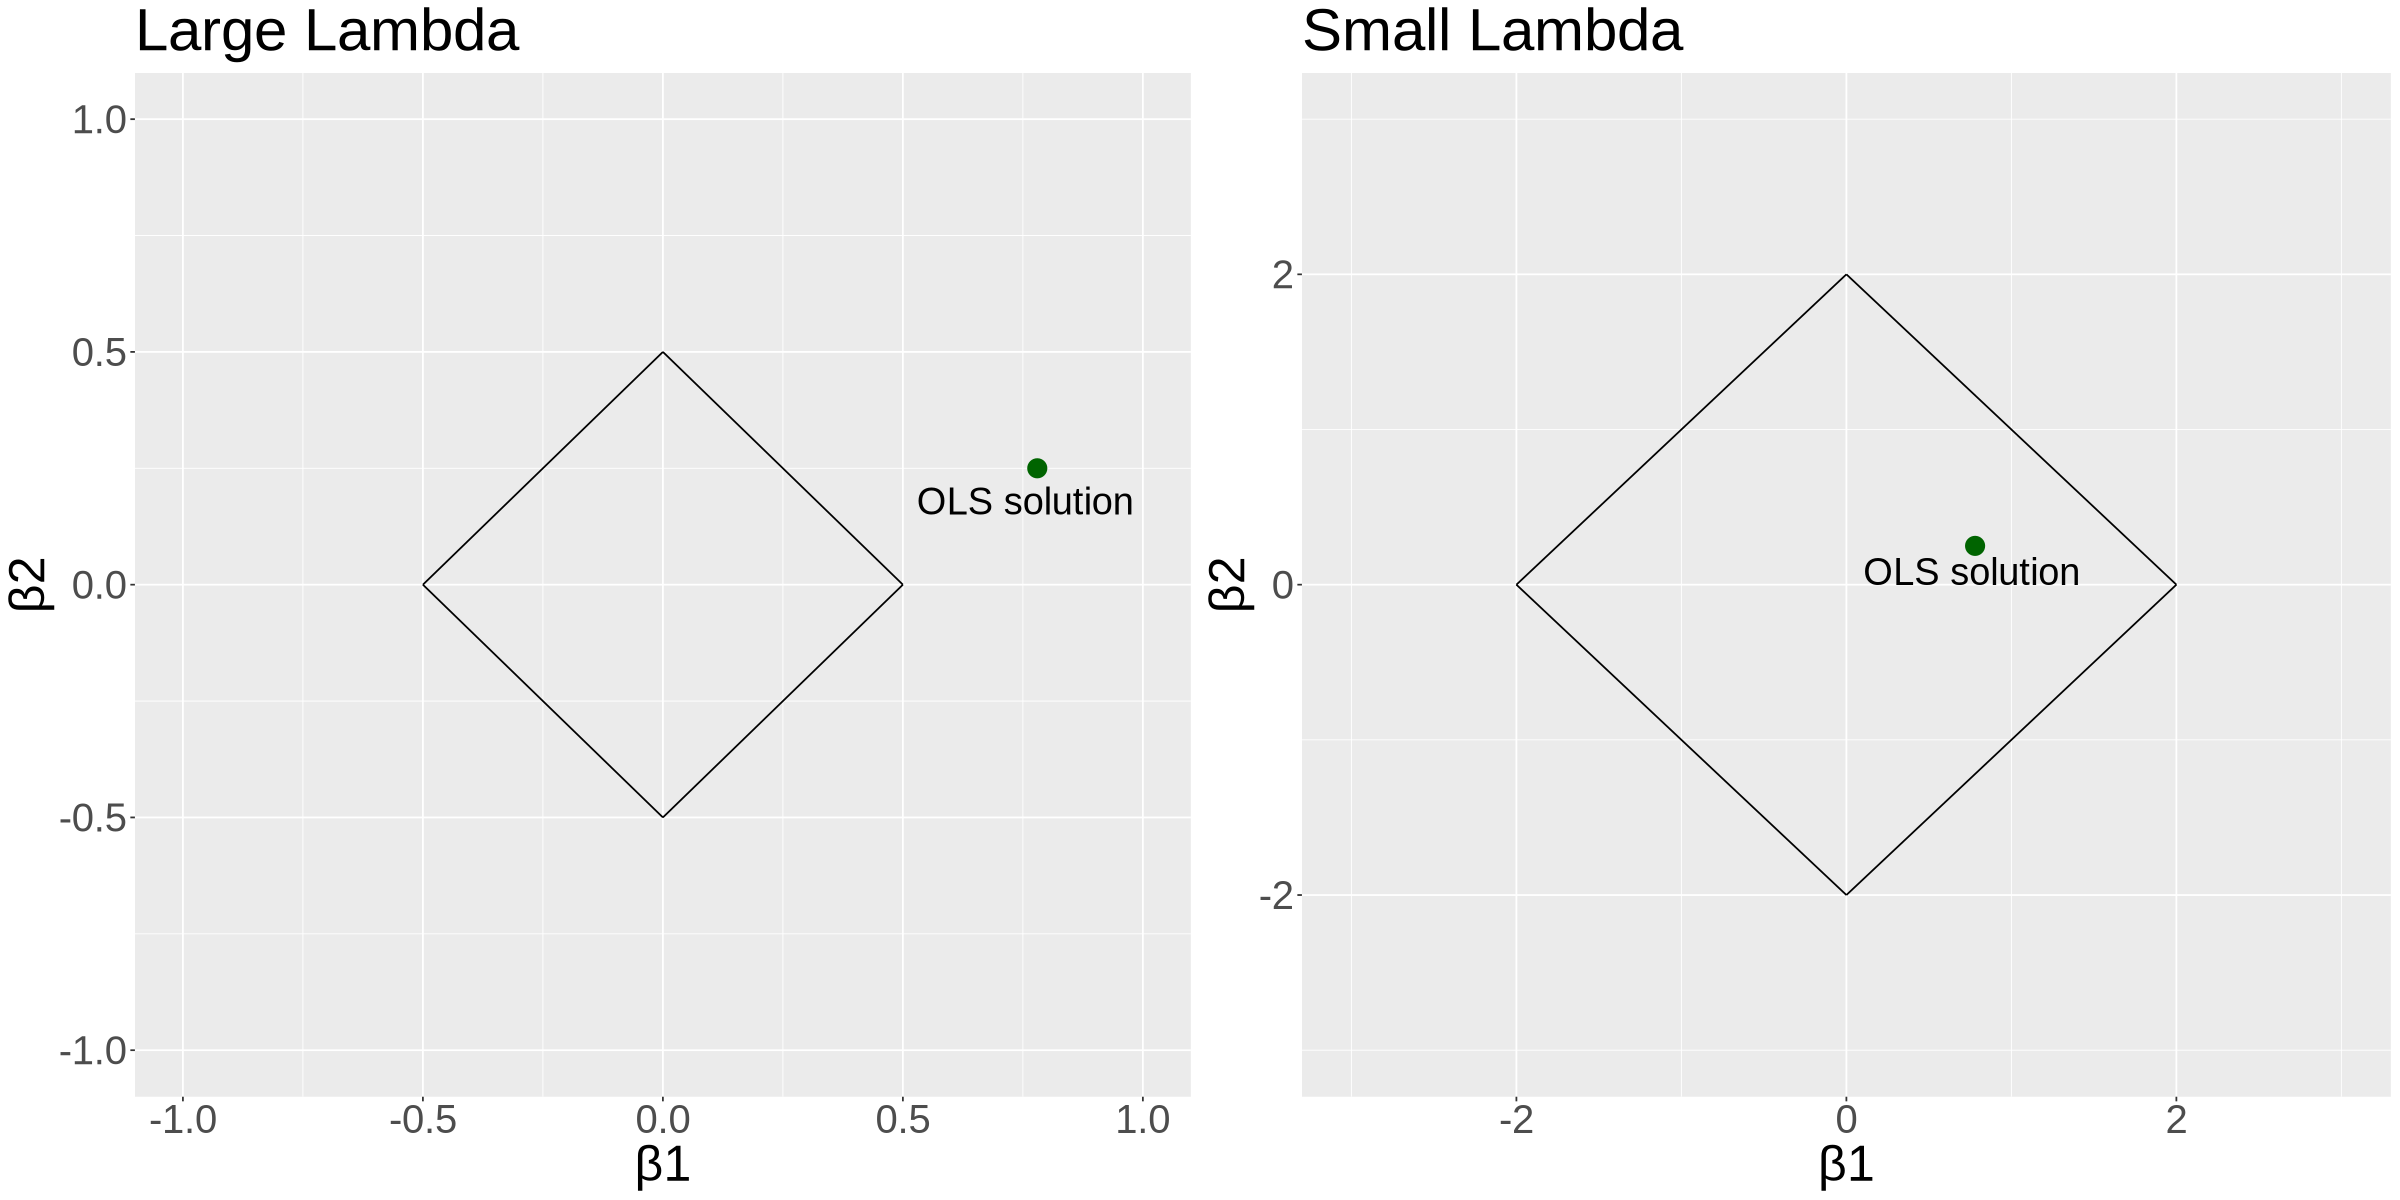

In [16]:
grid.arrange(lasso_large_lambda, lasso_small_lambda, ncol=2)

## 2.3 Fitting LASSO 

### Prostate Cancer Data Problem

- Do you want to learn how to fit LASSO to a dataset? 

### Let's start by loading the data

In [17]:
# Loading the data
data("Prostate")

cancer_prostate <- 
    tibble(Prostate) 

# Printing the first 10 rows
head(cancer_prostate, 10)

lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.5798185,2.769459,50,-1.3862944,0,-1.386294,6,0,-0.4307829
-0.9942523,3.319626,58,-1.3862944,0,-1.386294,6,0,-0.1625189
-0.5108256,2.691243,74,-1.3862944,0,-1.386294,7,20,-0.1625189
-1.2039728,3.282789,58,-1.3862944,0,-1.386294,6,0,-0.1625189
0.7514161,3.432373,62,-1.3862944,0,-1.386294,6,0,0.3715636
-1.0498221,3.228826,50,-1.3862944,0,-1.386294,6,0,0.7654678
0.7371641,3.473518,64,0.6151856,0,-1.386294,6,0,0.7654678
0.6931472,3.539509,58,1.5368672,0,-1.386294,6,0,0.8544153
-0.7765288,3.539509,47,-1.3862944,0,-1.386294,6,0,1.0473190


### Data Dictionary
- **lcavol**: log(cancer volume) 
- **lweight**: log(prostate weight)
- **age**: age of the patient
- **lbph**: log(amount of benign prostatic hyperplasia)
- **svi**: Seminal vesicle invasion. (True or False)
- **lcp**: log(capsular penetration)
- **gleason**: Gleason score. The Gleason score measures how abnormal the tissue looks. The lower the score is, the more the cells look like regular prostate tissue. You can learn more about the [Gleason Score here](https://www.pcf.org/about-prostate-cancer/diagnosis-staging-prostate-cancer/gleason-score-isup-grade/)
- **pgg45**: Percentage Gleason scores 4 or 5. Scores 4 and 5 are considered very high; the cells barely look like normal prostate tissue.
- **lpsa**: log(prostate-specific antigen)

- Unfortunately, the units for the variables are not readily available and are unknown. 

- However, remember that the units are fundamental to interpreting the model. 

- So always make sure you know what the units are (even though I'm not sure what the units are in this case &#x1F609;). 


## Step 1: Data splitting

Even though we will be fitting the LASSO method and not comparing it with other models (such as., k-nn regression), there's still plenty we still need to learn. For example, we still need to figure out the following:

1. which covariates are relevant? 
2. how much regularization should we use?

We will use the data to make these decisions. But once we've selected the model, we need to be able to assess our model. We must use different data to do this. 

### Exercise 1

So let's start by splitting the dataset into two sets: (1) train set, with 70% of the rows; and (2) test set, with the remaining 30%. 

_Save the train set in an object called `cancer_train` and test set in `cancer_test`._



In [20]:
set.seed(20230530) # Do not change this

cancer_prostate_split <- initial_split(cancer_prostate, prop = 0.7)

cancer_train <- training(cancer_prostate_split)
cancer_test <- testing(cancer_prostate_split) 

### Exercise 2 

Let's take a look at some summary quantities of our data. First, remove the `svi` variable (we don't want to calculate the summary of a binary variable). 

In [21]:
cancer_train |> 
    select(-svi) |>
    summary()

     lcavol           lweight           age             lbph        
 Min.   :-1.2040   Min.   :2.691   Min.   :41.00   Min.   :-1.3863  
 1st Qu.: 0.5276   1st Qu.:3.372   1st Qu.:60.50   1st Qu.:-1.3863  
 Median : 1.4469   Median :3.649   Median :65.00   Median : 0.4383  
 Mean   : 1.3852   Mean   :3.677   Mean   :63.88   Mean   : 0.1584  
 3rd Qu.: 2.3491   3rd Qu.:3.877   3rd Qu.:68.00   3rd Qu.: 1.5475  
 Max.   : 3.8210   Max.   :6.108   Max.   :79.00   Max.   : 2.3263  
      lcp             gleason          pgg45          lpsa        
 Min.   :-1.3863   Min.   :6.000   Min.   :  0   Min.   :-0.4308  
 1st Qu.:-1.3863   1st Qu.:6.000   1st Qu.:  0   1st Qu.: 1.7136  
 Median :-0.7985   Median :7.000   Median : 15   Median : 2.5688  
 Mean   :-0.2143   Mean   :6.716   Mean   : 25   Mean   : 2.4757  
 3rd Qu.: 1.0663   3rd Qu.:7.000   3rd Qu.: 45   3rd Qu.: 3.0347  
 Max.   : 2.9042   Max.   :9.000   Max.   :100   Max.   : 5.5829  

## Step 2: Data Standardization

- <span style='color: red'>**DO NOT FORGET:**</span> we need to standardize the data before applying LASSO!

- Luckily for us, `glmnet` automatically standardizes the data for us! 


## Step 3: Calling  the `glmnet` function

- `glmnet` is much more flexible than we need here. 

- So, let's focus only on the arguments that matter to us;

- You can learn more with [`glmnet`'s vignette](https://glmnet.stanford.edu/articles/glmnet.html) or calling help `?glmnet`



### Exercise 3

To train a regression using LASSO, we can use the package `glmnet` in R. A few points to keep in mind:

- `glmnet` actually uses a penalty function that generalizes LASSO. So, to reduce that generalization to LASSO, we set alpha = 1, which is the default. 


- we can define a grid of values to evaluate by providing `lambda`, or we can just say how many lambdas we want to try out, and the function will define the values on its own. 

Now, fill in the code below to run LASSO with our `cancer_train` dataset. We want to try out 200 values for `lambda`. Store the model in an object named `lasso_cancer_fitted`.

In [26]:
set.seed(20230530)

# Fill in the code

lasso_cancer_fitted <- # The variable to store the fitted model
    glmnet(
        x = cancer_train |> select(-lpsa),  # First argument is the covariates (note that we need at least two columns)
        y = cancer_train$lpsa,  # Second argument is the response
        alpha = 1, # This is the default and is equivalent to LASSO 
        nlambda = 100, # the number of lambda values to try (default is 100)
        #lambda  = ..., # alternatively, the values of lambda you want try
        standardize = TRUE, # Default value is TRUE
    )

## Step 4: Extracting information from fitted model

- The fitted model is a complex R object. 

- We will use some functions to extract the main parts of our model

### Exercise 4: the solution Path

If we call the `plot` function directly on the fitted model and it will show the value of the coefficients for different values of lambda. We need to specify `xvar = 'lambda'`.

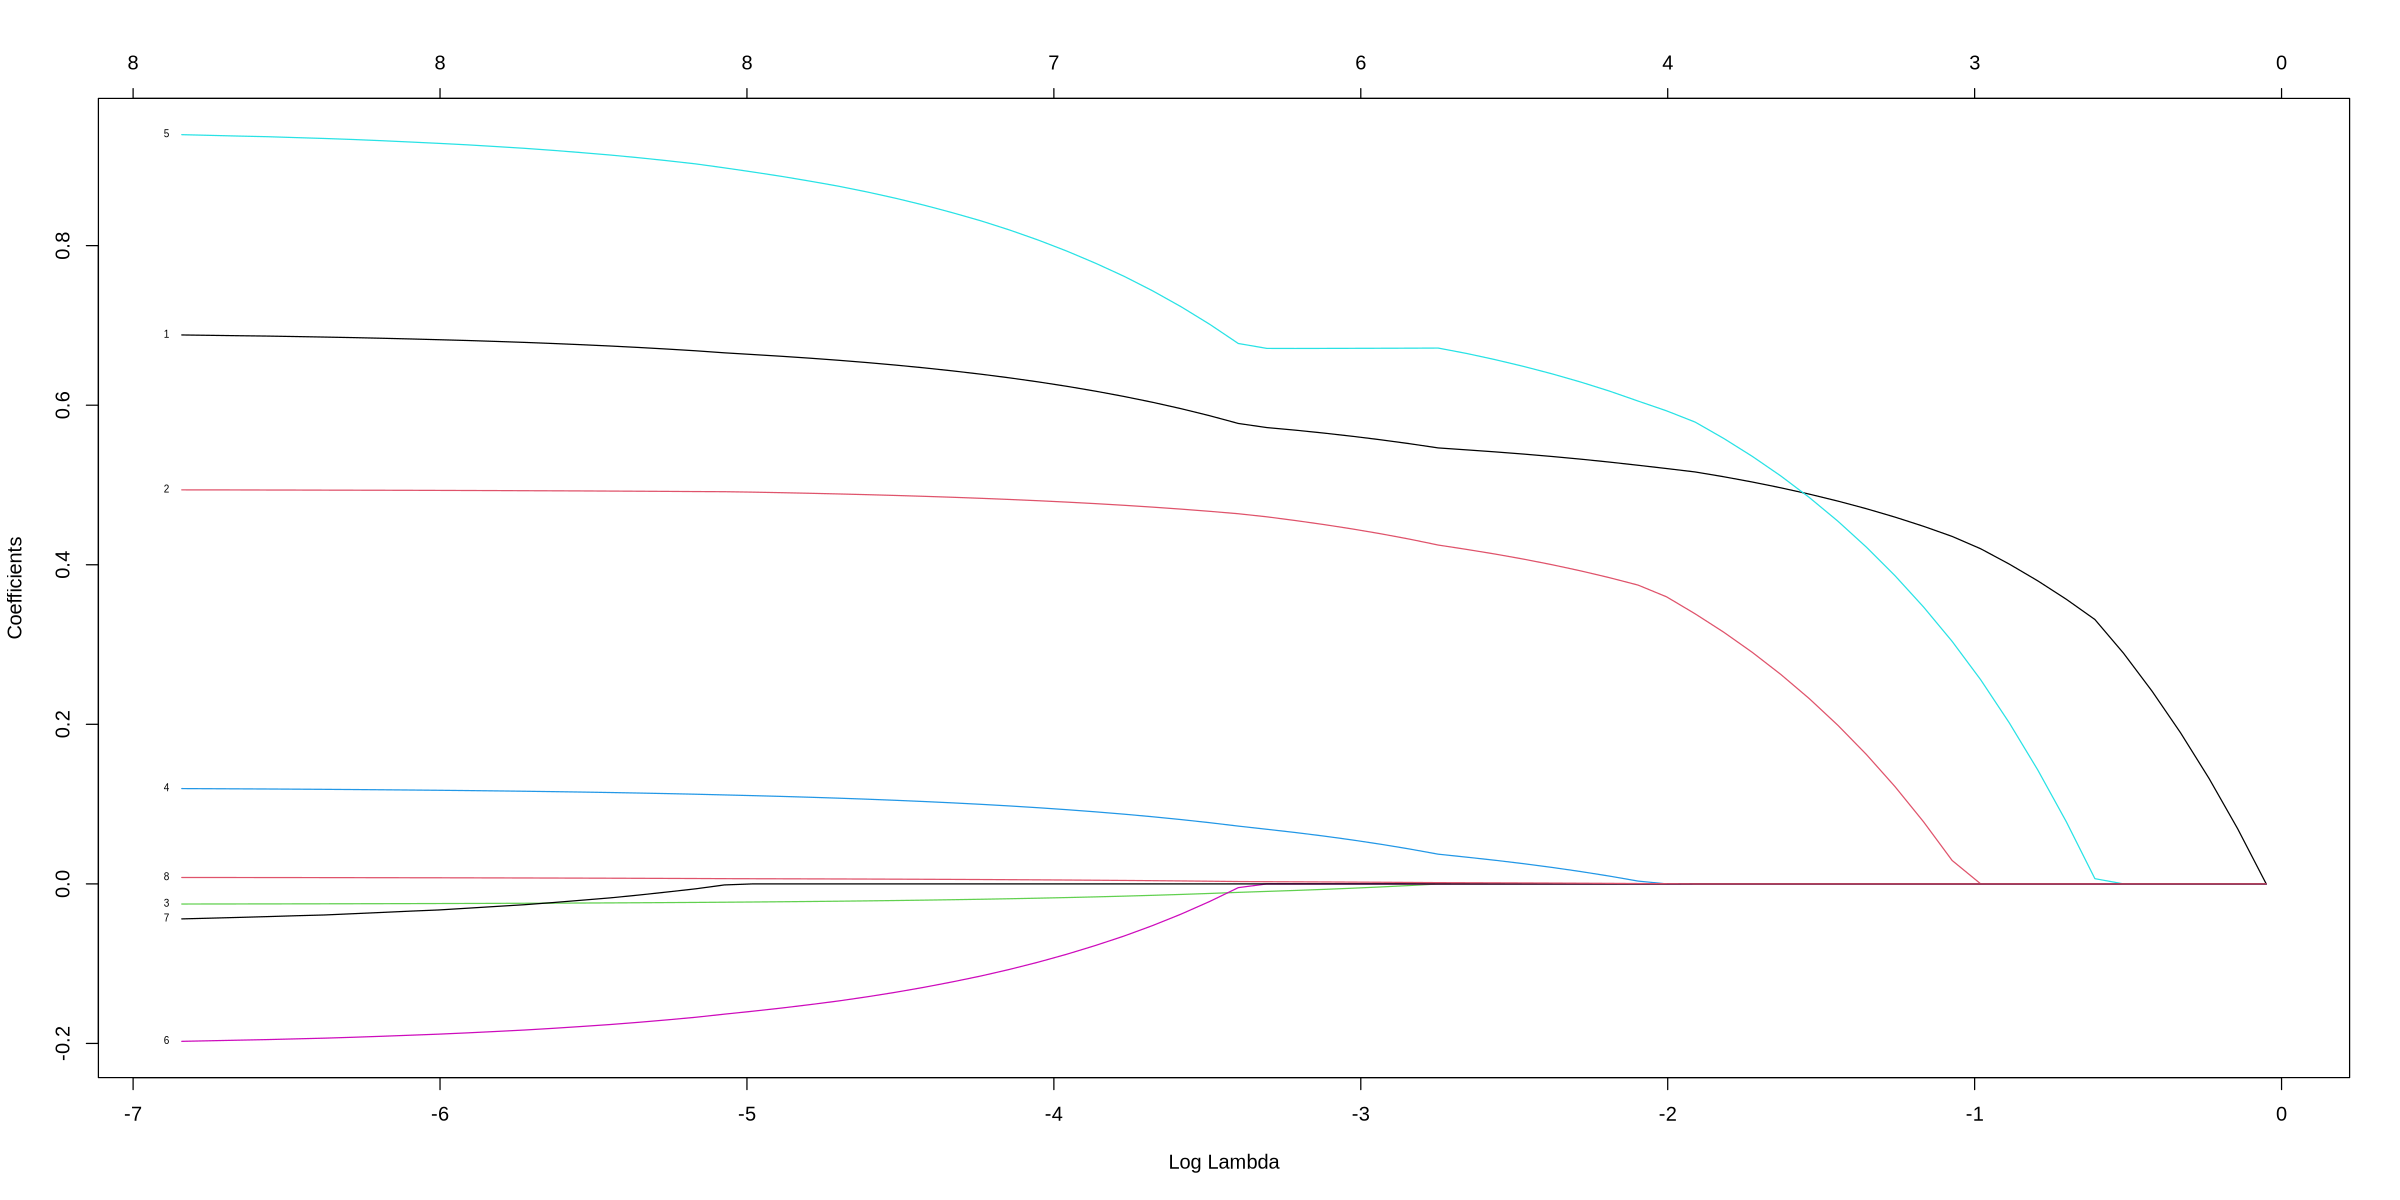

In [31]:
plot(lasso_cancer_fitted, xvar = 'lambda', label = TRUE)

### Exercise 5: grabbing the coefficients

To see what the coefficients are, we call the `coef` function. Naturally, the values of coefficients depend on lambda. We can specify one or more values of lambda using the `s` argument. 
- If you don't specify an `s` value, coefficients for all fitted $\lambda$ will be returned;
- If you pick a $\lambda$ not fitted by the model, it returns an "approximation" of the coefficients via interpolation; usually, this approximation is quite accurate. 

Obtain the coefficients for the model with $\lambda=0.4$ and $\lambda=0.1$

In [32]:
coef(lasso_cancer_fitted, s = c(0.4, 0.1)) # here lambda is called `s` (as in "size" of the model, but lower s --> larger models)

9 x 2 sparse Matrix of class "dgCMatrix"
                   s1          s2
(Intercept) 1.8562663 0.103952007
lcavol      0.4070325 0.533074295
lweight     .         0.393956757
age         .         .          
lbph        .         0.016553795
svi         0.2193038 0.631180573
lcp         .         .          
gleason     .         .          
pgg45       .         0.000885282

### Example 6: 

You can specify `exact = TRUE` to fit the model for a given $\lambda$ and obtain the exact coefficients.
  - In this case, we need to provide $x$ and $y$ again;

In [33]:
coef(lasso_cancer_fitted, 
     s = 0.4, 
     exact = TRUE, 
     x = cancer_train |> select(-lpsa),
     y = cancer_train$lpsa)

9 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) 1.8562674
lcavol      0.4070314
lweight     .        
age         .        
lbph        .        
svi         0.2193055
lcp         .        
gleason     .        
pgg45       .        

## Step 5: making predictions

### Exercise 6

For prediction, the flow is very similar. We call the `predict` function and specify one or more lambda values we want in the `s` argument, but we also need to provide the `newx` matrix containing the data to be used for prediction. 

Unfortunately, `glmnet` doesn't play well with data frames and requires a matrix for `newx`.

Use `cancer_train` data to obtain the predictions for the model `lasso_cancer_fitted` using  $\lambda=0.4$ and $\lambda=0.1$.

In [36]:
     
predict(lasso_cancer_fitted, # Fitted model
    newx = cancer_train |> select(-svi) |> as.matrix(), # A matrix (yes, tibble don't work) containing the data for prediction,
    s = c(0.4, 0.1) # one or more values of lambda
   ) 

s1,s2
1.626458,1.76226098
2.626921,2.52405890
1.741002,0.98530822
2.502675,2.24925369
2.381877,1.75573660
1.147554,-0.01636371
1.834380,1.01905975
2.290393,1.92729390
3.539381,4.99503185
1.062191,-0.14267235


## 2.4 Tuning: the process of selecting  $\lambda$: 

- We saw that `glmnet` fits LASSO for many different values of $\lambda$. Which $\lambda$ should we use? 

- This is called hyper-parameter tuning, and we usually do this using cross-validation. 

- We decide on a metric, such as MSE, and pick $\lambda$ with the best performance in the cross-validation set. 

### Exercise 7

Luckily for us, we don't need to do this ourselves. Instead, we can call `cv.glmnet`, which will do this entire process for us. The function is very similar to `glmnet`. Fill in the code below to run `cv.glmnet`. 

_Save the fitted model in an object called `cancer_cv_lasso`._

In [40]:
cancer_cv_lasso <- 
    cv.glmnet(
        x = cancer_train |> select(-svi) |> as.matrix(), # Covariates
        y = cancer_train$svi, # Response
        lambda = NULL, # A sequence of lambdas. Default lets the function choose its own sequence. 
        nfolds = 10, # number of folds to be used in the cross validation
        standardize = TRUE
    )

print(cancer_cv_lasso)


Call:  cv.glmnet(x = as.matrix(select(cancer_train, -svi)), y = cancer_train$svi,      lambda = NULL, nfolds = 10, standardize = TRUE) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.05086    21 0.08679 0.01240       2
1se 0.10705    13 0.09817 0.01405       2


You can also select the measure you want to use to select $\lambda$ (e.g., MSE, MAE) using `type.measure`. 

Check the documentation for more info: `?cv.glmnet`.

## `plot` functions for `cv.glmnet`

The `coef` and `predict` functions work exactly the same as for the `glmnet`. But the plot function is a little different. Let's check! 

### Exercise 8

Call the `plot` function directly on the fitted `cv.glmnet` model. 

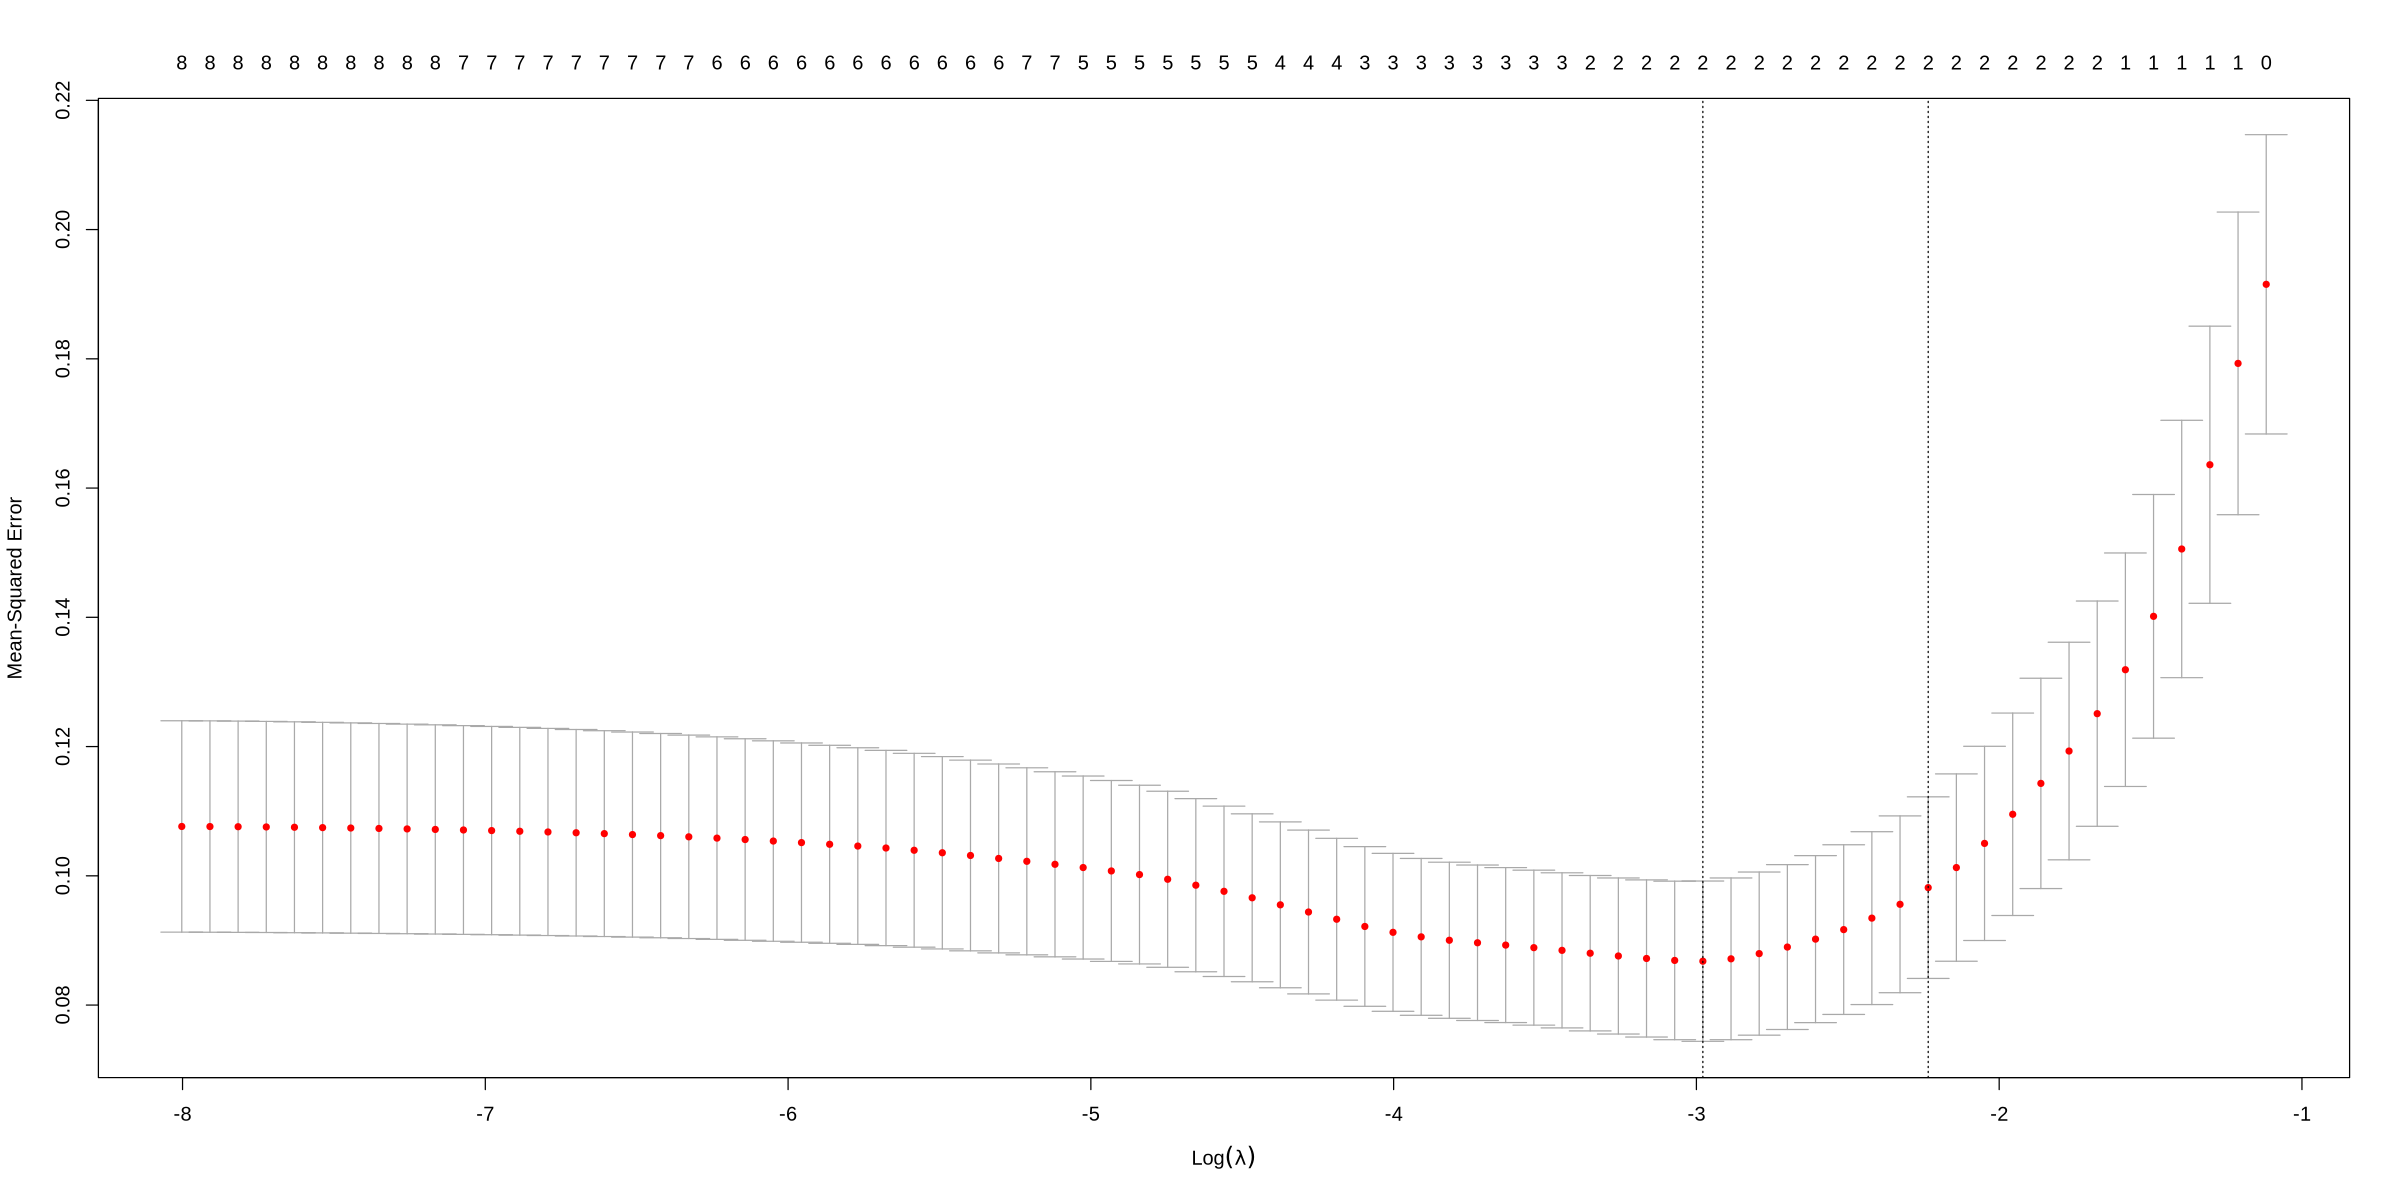

In [41]:
plot(cancer_cv_lasso)

- The plot shows the estimated MSE for different value of lambdas; 

- The numbers at the top show how many variables are included in the model for each lambda; 

- The error bars represent the variation of MSE over the different folds of the cross-validation;

- First vertical dotted line (on the left), the best CV $\lambda$ value; 

- Second vertical dotted line (on the right), the most regularized model (highest $\lambda$) that the CV performance is 1 std. dev. from the best one. 

## `coef`, and `predict` functions for `cv.glmnet`

- They work pretty much the same way;

- Except now we can use two string for `s` argument:
    - "lambda.1se"
    - "lambda.min"

In [42]:
coef(cancer_cv_lasso, 
    s = 'lambda.1se') # two new possible values:  "lambda.min" or "lambda.1se" (default)

9 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) 0.18227275
lcavol      .         
lweight     .         
age         .         
lbph        .         
lcp         0.13442401
gleason     .         
pgg45       .         
lpsa        0.04049964

In [43]:
coef(cancer_cv_lasso, 
    s = 'lambda.min')

9 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) 0.11748312
lcavol      .         
lweight     .         
age         .         
lbph        .         
lcp         0.15958655
gleason     .         
pgg45       .         
lpsa        0.06884773

In [44]:
predict(
    cancer_cv_lasso, 
    newx = cancer_train |> select(-lpsa) |> as.matrix(),
    s = 'lambda.1se') 

lambda.1se
0.1822728
1.5316858
0.1822728
1.8022582
1.3972618
0.1822728
0.1822728
3.4222436
2.7466749
0.1822728


## 2.5 Some "caveats"


**LASSO and categorical variable**

- When we fit categorical data, we use dummy variables (one-hot-encoding); 


- What happens if LASSO removes one of the dummy variables but leaves the others? Does it make sense? 


- There are some LASSO extensions, such as Group LASSO, that deal with this. 

**LASSO Inference**

- The LASSO method gives biased estimates for the parameters; (you will see this in the worksheet)
    - Biased estimates are not the end of the world, but can make inference trickier; 

<br>

- Confidence intervals are not immediately available for LASSO
   - There are a few proposals for confidence intervals available for coefficients and hypothesis testing for LASSO models; 

- The trickier part is that inference for LASSO triggers the post-selection inference problem;
  - I have prepared an activity to walk you through this problem and illustrate the bias in the LASSO estimate. 
  
<br>
  
- An approach to deal with this is to use data split. 
    - In the first split, we run LASSO to select the variables; 
    - In the second split, we fit OLS and use that inference; 

## 2.6 A comment on Ridge Regression

Another very common regularization technique is to use the squares of $\beta$s instead of the absolute value. 

In other words, we fit the model by minimizing the following function:

$$
Ridge(\beta) = \sum_{i=1}^n \left(y_i - \beta_0 - \beta_1X_{i1} - \ldots - \beta_p X_{ip}\right)^2 + {\color{red}{\lambda\sum_{i=1}^p \beta_i^2}}
$$

This model is called ridge regression. 

Ridge regression performs pretty well for prediction problems. The solutions of ridge regression don't zero any of the coefficients. So, we end up with more complex models, which are harder to interpret than Lasso.

# Prediction *vs.* Inference

In [1]:
library(tidyverse)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(faraway)
library(mltools)

options(repr.plot.width=10, repr.plot.height=8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na




## 1. Statistical Modelling

In statistical modelling, the objective is to capture how a response variable, $Y$, is associated with a set of input variables, $\mathbf{X}=\left(X_1, X_2, ..., X_p\right)$. 

There are two main reasons that motivate us to model the relationship between $\mathbf{X}$ and $Y$: (1) prediction; and (2) inference. 

### 1.1 Prediction

Everyone is familiar with the usefulness of prediction. In fact, we are constantly making predictions on a daily basis. For example, 
You look at the weather outside and decide whether you should bring an umbrella with you or not. Or, when you are driving and see a pedestrian approaching the street, you predict whether the pedestrian will walk in front of your car or wait. Many variables could affect the response, such as, whether the pedestrian saw your car, if the pedestrian thinks you are going to stop on time, how late the pedestrian is to arrive at his/her destination, etc. These examples are very informal prediction processes. You make a judgment call based on your knowledge and past experiences.  Not very scientific, but still useful predictions! 

Statistical modelling, however, will allow you to model the relationship between the response variable and the covariates considered to be associated with it, based on data. Besides being less subjective and providing you with a methodologically sound way to learn about the relationship between $Y$ and $\mathbf{X}$, statistical modelling has the crucial advantage of also giving you a measure of uncertainty. A few examples of questions questions that can be answered with prediction: 

- How much will be the selling price of a house with three bedrooms, 1300 sq. feet in Kitsilano? 
- Given that my blood albumin level is 44g/L, do I have a liver problem?
- What will be my final grade in STAT 301, given that I'm studying 5 hours per week and got 85% in the midterm? 
- Is there a difference in final grades between two sessions of a course: one online and the other in-person? 


#### Linear Regression as a Predictor

- The conditional expectation is the best predictor of $Y$ given a vector of variables $\boldsymbol{X}$: $E[Y|\boldsymbol{X}]$


- A LR assumes a linear form for this conditional expectation

    - In general, this is only an *assumed* model, an *approximation* to the real form of $E[Y|\boldsymbol{X}]$


- If the conditional expectation is not linear, the LR can still be used as a predictor of $Y$ but it may not be the *best* one!
    - For example, in DSCI100 you have used kNN to estimate the conditional expectation

### 1.2 Inference

In some cases, we are interested in understanding the association between $Y$ and $\mathbf{X}$. We want to know how $Y$ varies when $\mathbf{X}$ changes. For example,

- Are the sales of the new iPhone 15 related to its price?
- What are the most relevant features associated with the price of a house: the number of bedrooms or the number of bathrooms? 
- Is $\text{CO}_2$ associated with temperature elevation? 
- Does the sex of the applicants influence the chance of admission at the University of British Columbia?
- Has the social distancing measures influenced the spread of COVID-19 in Canada?

In all the questions above, we are not primarily interested in making highly accurate predictions. Instead, we want to understand the relation between different variables. 

Naturally, in many cases, we are interested in both: inference and prediction. For example, one could be interested in answering "How do social distancing measures influence the spread of COVID-19?" but also in answering  "How many cases can we expect to have if we implement some social distancing policies?". 

Linear Models are an excellent initial approach in these cases, as they are highly interpretable and still perform reasonably well in many cases. Fro example, a Neural Network **might** give much better predictions, but their interpretation is quite tricky, if possible at all.  Notwithstanding, if we are only interested in accurate predictions, these models can be extremely useful. In other situations, however, our primary interest is in inference and we are willing to sacrifice some prediction performance for a more interpretable model. 

## PART I: Post-inference problem

<img src="https://media.istockphoto.com/id/1160233801/photo/vegan-food-hands-dipping-hummus.jpg?s=1024x1024&w=is&k=20&c=grGNgPaRp1AikrwfDUid71MSCCnkudmbRwgY6gkh_Cs=" width=500>


There are many aspects involved in selecting a model that goes beyond variable selection, for example,

- Do we want a parametric or non-parametric approach? 
- Do we want to assume a functional form for the relationship between $Y$ and $\mathbf{X}$ (e.g., linear, quadratic, exponential, logarithmic)?
- Prediction performance. 
- Is model interpretability important?

In previous lectures, we have discussed different ways of selecting models for estimation problems in which the interpretability of the model is crucial.

In particular, we have learned many ways of comparing models based on their $R^2$, adjusted $R^2$, or other test statistics. We introduced the stepwise selection algorithms to automate the selection process.

### Can we still make inference using the selected models??

We will investigate this question in a simulation study using the forward selection algorithm to select a generative model. 